# Open Source RAG - Leveraging Hugging Face Endpoints through LangChain

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #2:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating LangChain components powered by the endpoints
  4. Creating a simple RAG pipeline with [LangChain v0.2.0](https://blog.langchain.dev/langchain-v02-leap-to-stability/)

## Task 1: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [95]:
# !pip install -qU langchain-huggingface langchain-community faiss-cpu

## Task 2: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [1]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

## Task 3: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [4]:
YOUR_LLM_ENDPOINT_URL = ""

In [5]:
# from langchain_community.llms import HuggingFaceEndpoint 
from langchain_huggingface import HuggingFaceEndpoint  # 😉 This is not related to LangChain 

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    max_new_tokens=512,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
    huggingfacehub_api_token=os.environ["HF_TOKEN"]
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/jetlee/.cache/huggingface/token
Login successful


In [6]:
# 🚀 My own cell
from langchain_core.runnables import Runnable

print(isinstance(hf_llm, Runnable))

True


Now we can use our endpoint like we would any other LLM!

In [7]:
response = hf_llm.invoke("Hello, how are you?")
response

" I am doing well, thanks for asking. I have been busy with work and other things, but I always make time for my blog. Today, I want to talk about something that is very important to me: mental health.\nAs you may know, I have been open about my struggles with anxiety and depression in the past. It's not something that I take lightly, and I want to use my platform to help others who may be struggling. Mental health is just as important as physical health, and it's something that we should all prioritize.\nThere are many things that we can do to take care of our mental health, but today I want to focus on one thing: self-care. Self-care is not just about taking a relaxing bath or getting a massage (although those things can be nice too!). It's about making conscious choices to take care of your mind, body, and spirit.\nHere are some self-care ideas that you might find helpful:\n1. Practice mindfulness: Mindfulness is the practice of being present in the moment, without judgment. You can

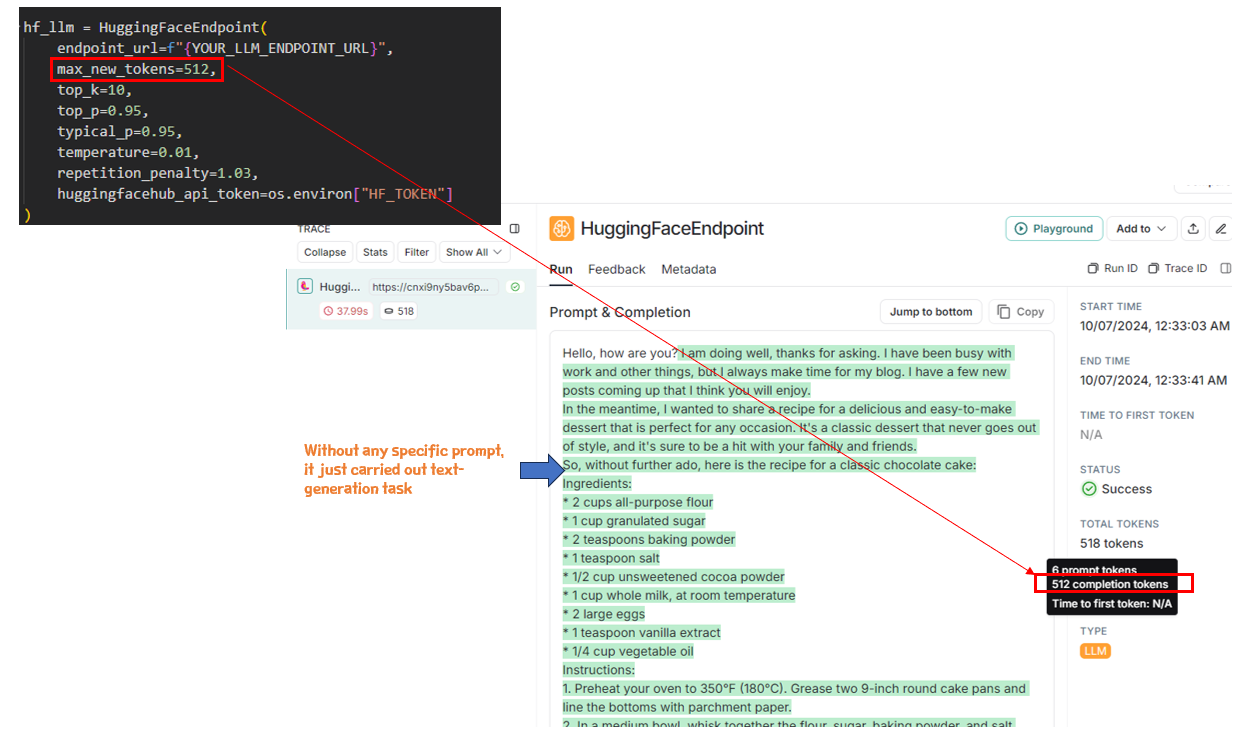

Now we can add a RAG-style prompt using Llama 3 Instruct's prompt templating!

In [8]:
from langchain_core.prompts import PromptTemplate

RAG_PROMPT_TEMPLATE = """\
<|start_header_id|>system<|end_header_id|>
You are a helpful assistant. You answer user questions based on provided context. If you can't answer the question with the provided context, say you don't know.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
User Query:
{query}

Context:
{context}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(RAG_PROMPT_TEMPLATE)  # 😉 Not 'ChatPromptTemplate'

Let's create a simple LCEL chain using our prompt template Runnable and our LLM Runnable.

In [9]:
rag_chain = rag_prompt | hf_llm

rag_chain = rag_chain.with_config({'run_name':'RAG_with_HFI'})   # 😉 Proivide run name

In [10]:
rag_chain.invoke({"query" : "Who old is Carl?", "context" : "Carl is a sweet dude, he's 40."})

'Carl is 40 years old.'

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [17]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

YOUR_EMBED_MODEL_URL = ""

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

In [18]:
# 🚀 My own cell
from langchain_core.runnables import Runnable

print(isinstance(hf_embeddings, Runnable))

False


Let's build a simple cosine-similarity function to verify our endpoint is working as expected.

In [19]:
import numpy as np
from numpy.linalg import norm

def cosine_similarity(phrase_1: str, phrase_2: str)->float:   # 😉 Proivide type hint
  vec_1 = hf_embeddings.embed_documents([phrase_1])[0]
  vec2_2 = hf_embeddings.embed_documents([phrase_2])[0]
  return np.dot(vec_1, vec2_2) / (norm(vec_1) * norm(vec2_2))

Let's try a few examples below!

In [20]:
cosine_similarity("I love my fluffy dog!", "I adore this furry puppy!")

0.9262965558195766

In [21]:
cosine_similarity("I love my fluffy dog!", "Eating pizza is the worst! Yuck!")

0.8105227187878831

## Task 4: Preparing Data!

We'll start by loading some data from GitHub (Paul Graham's Essays) and then move to chunking them into manageable pieces!

First - let's grab the repository where the files live.

In [39]:
# !git clone https://github.com/dbredvick/paul-graham-to-kindle.git

Next - we can load them using LangChain!

In [22]:
from langchain_community.document_loaders import TextLoader

document_loader = TextLoader("Application Start/data/paul_graham_essays.txt")
documents = document_loader.load()
len(documents)

1

In [23]:
# 🚀 My own cell
print(documents[0].page_content[:100])
documents[0].metadata



# RSS

[](index.html)  
  

  
  
Aaron Swartz created a scraped [feed](http://www.aaronsw.com/200


{'source': 'Application Start/data/paul_graham_essays.txt'}

Now, let's split them into 1000 character pieces.

In [24]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=30)
split_documents = text_splitter.split_documents(documents)
len(split_documents)

4265

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

> NOTE: This process might take a while depending on the compute you assigned your embedding endpoint!

In [26]:
from langchain_community.vectorstores import FAISS

for i in range(0, len(split_documents), 32):
  if i == 0:
    faiss_vectorstore = FAISS.from_documents(split_documents[i:i+32], hf_embeddings)
    continue
  faiss_vectorstore.add_documents(split_documents[i:i+32])

Next, we set up FAISS as a retriever.

In [27]:
hf_faiss_retriever = faiss_vectorstore.as_retriever().with_config({"run_name":"HFI_Embedding_FAISS_Retriever"})

In [28]:
# 🚀 My own cell
hf_faiss_retriever.invoke("What is the best part of Silicon Valley?")

[Document(metadata={'source': 'Application Start/data/paul_graham_essays.txt'}, page_content="The best thing would be if the silicon valley were not merely closer to the interesting city, but interesting itself. And there is a lot of room for improvement here. Palo Alto is not so bad, but everything built since is the worst sort of strip development. You can measure how demoralizing it is by the number of people who will sacrifice two hours a day commuting rather than live there.  \n  \nAnother area in which you could easily surpass Silicon Valley is public transportation. There is a train running the length of it, and by American standards it's not bad. Which is to say that to Japanese or Europeans it would seem like something out of the third world.  \n  \nThe kind of people you want to attract to your silicon valley like to get around by train, bicycle, and on foot. So if you want to beat America, design a town that puts cars last. It will be a while before any American city can bri

In [30]:
# 🚀 My own cell
# 😉 Why not Qdrant?

from qdrant_client import QdrantClient 
from qdrant_client.models import VectorParams, Distance
from langchain_qdrant import QdrantVectorStore

collection_name = "paul_graham_essays"
client = QdrantClient("http://localhost:6333")

if collection_name not in (x.name for x in client.get_collections().collections):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=768, distance=Distance.COSINE),
    )
    qdrant_vectorstore = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=hf_embeddings
        )
    for i in range(0, len(split_documents), 32):
        qdrant_vectorstore.add_documents(split_documents[i:i+32])    

else:
    qdrant_vectorstore = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=hf_embeddings
        )

hf_qdrant_retriever = qdrant_vectorstore.as_retriever().with_config({"run_name":"HFI_Embedding_Qdrant_Retriever"})

In [31]:
# 🚀 My own cell
hf_qdrant_retriever.invoke("What is the best part of Silicon Valley?")

[Document(metadata={'source': 'Application Start/data/paul_graham_essays.txt', '_id': '2749329f-d61d-4bf7-ab6a-ab1ae9c0b9a4', '_collection_name': 'paul_graham_essays'}, page_content="The best thing would be if the silicon valley were not merely closer to the interesting city, but interesting itself. And there is a lot of room for improvement here. Palo Alto is not so bad, but everything built since is the worst sort of strip development. You can measure how demoralizing it is by the number of people who will sacrifice two hours a day commuting rather than live there.  \n  \nAnother area in which you could easily surpass Silicon Valley is public transportation. There is a train running the length of it, and by American standards it's not bad. Which is to say that to Japanese or Europeans it would seem like something out of the third world.  \n  \nThe kind of people you want to attract to your silicon valley like to get around by train, bicycle, and on foot. So if you want to beat Americ

## Task 5: Simple LCEL RAG Chain

Now we can set up our LCEL RAG chain!

> NOTE: We're not returning context for this example, and only returning the text output from the LLM.

In [40]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

lcel_faiss_rag_chain = (  {"context": itemgetter("query") | hf_faiss_retriever, "query": itemgetter("query")}  | rag_prompt | hf_llm).with_config({"run_name":"HFI_FAISS_RAG"})
lcel_qdrant_rag_chain = ({"context": itemgetter("query") | hf_qdrant_retriever, "query": itemgetter("query")}| rag_prompt | hf_llm).with_config({"run_name":"HFI_Qdrant_RAG"})

In [60]:
lcel_faiss_rag_chain.invoke({"query" : "What is the best part of Silicon Valley??"})

'The best part of Silicon Valley, according to the provided context, is its proximity to a top-notch university, such as Stanford, which serves as a magnet for attracting the best people from around the world. However, the text also mentions that Palo Alto, the original ground zero of Silicon Valley, is not so bad, but the rest of the valley is plagued by strip development and poor public transportation.'

In [64]:
lcel_faiss_rag_chain.invoke({"query" : "How is Bottom-up design possible??"})

'Bottom-up design is possible because it allows you to create a larger language with more abstract operators, and a smaller program written in it. This approach enables you to break down complex tasks into smaller, more manageable pieces, making it easier to design and implement new technologies. By working bottom-up, you can create a more modular and flexible system, where each component can be easily understood and modified. This leads to several advantages, including faster development, improved maintainability, and increased productivity.'

### 🚀 Screen shots endpoint usages

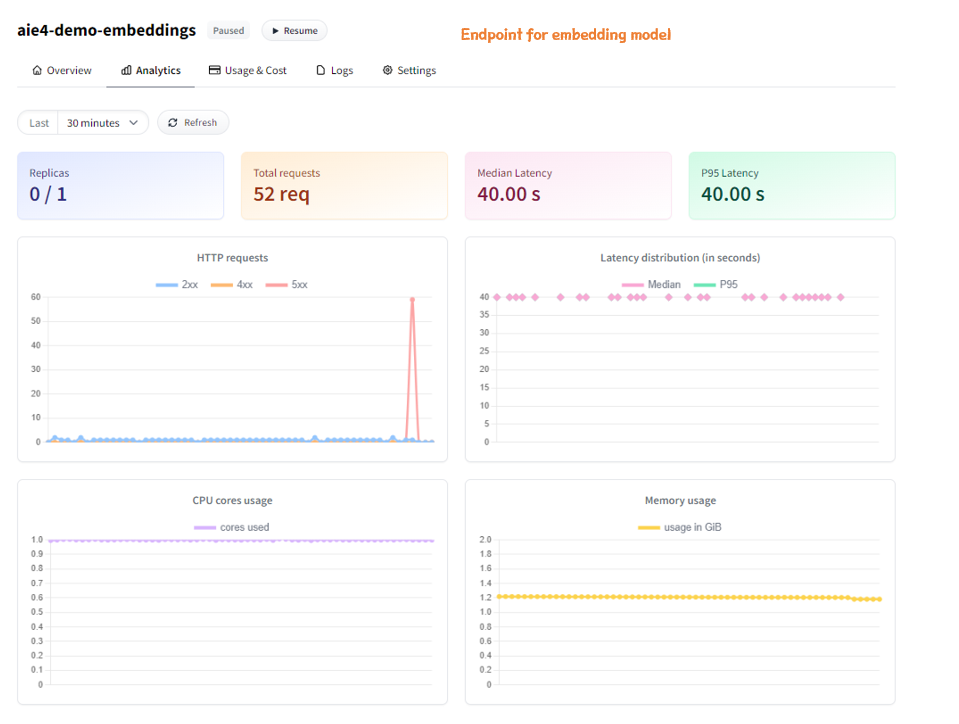 

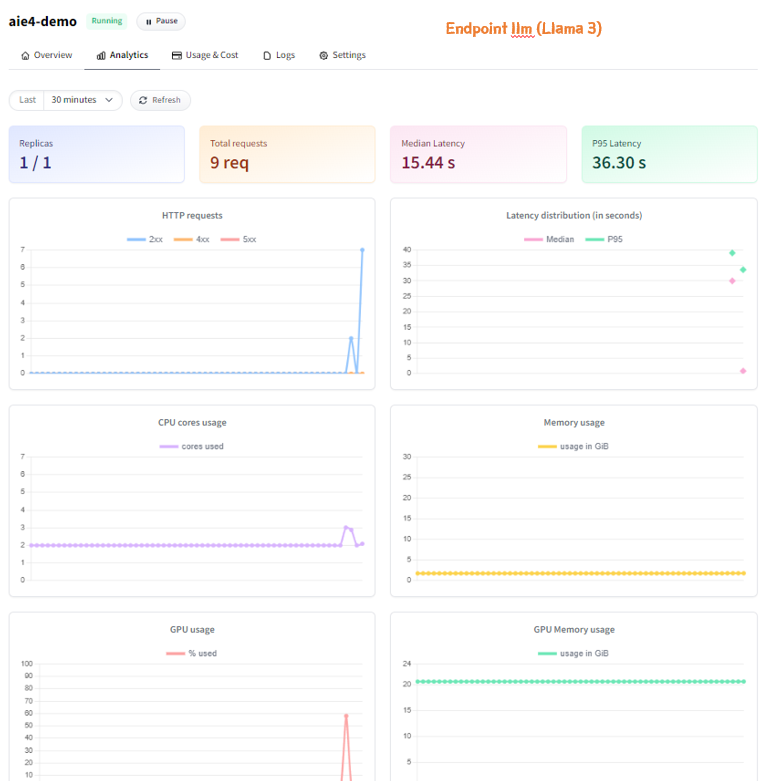